In [14]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from airplane import Airplane
from passenger import Passenger
from simulation import Simulation
from queues import *

In [15]:
ROWS = 30  # number of rows in the airplane
SEATS_PER_ROW = 6

# More realistic time constants (in seconds)
TIME_PER_STOP = 10  # time for a passenger to sit down
TIME_PER_SHUFFLE = 10  # time for a seat shuffle
TIME_PER_ROW = 2  # time to walk one row

In [16]:
def statistic(func):
    def wrapped():
        results = []
        for _ in range(1000):
            res = func()
            results.append(list(res.values()))
        data = pd.DataFrame(results, columns=list(res.keys()))
        # Add walking time to total boarding time
        data['time for boarding'] = (
            data['number of stops']*TIME_PER_STOP +
            data['number of seat shuffles']*TIME_PER_SHUFFLE +
            data['number of steps']*TIME_PER_ROW
        )
        _, ax = plt.subplots(1,2, figsize=(10,3))
        sns.histplot(data=data['time for boarding']/60, kde=True, ax = ax[0])
        sns.boxplot(data=data['time for boarding']/60, orient='h', ax = ax[1])
        ax[0].set_xlim(0, 60)
        ax[1].set_xlim(0, 60)
        ax[0].set_xlabel('Boarding Time (minutes)')
        ax[1].set_xlabel('Boarding Time (minutes)')
        plt.tight_layout()
        return data.mean()
    return wrapped

### Back to front boarding

number of steps                 181.000
number of stops                 151.000
number of seat shuffles          69.735
number of passengers seated     180.000
time for boarding              2569.350
dtype: float64

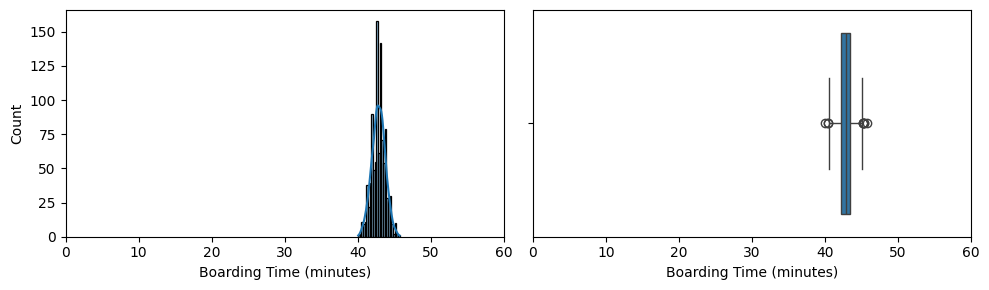

In [17]:
@statistic
def btf():
    airplane = Airplane(number_of_rows=ROWS, seats_per_row=SEATS_PER_ROW)
    sim = Simulation(airplane, BackToFront, max_iter=10000)
    return sim.run()

btf()

### WindowMiddleAisle

number of steps                 204.767
number of stops                 117.492
number of seat shuffles           0.000
number of passengers seated     180.000
time for boarding              1584.454
dtype: float64

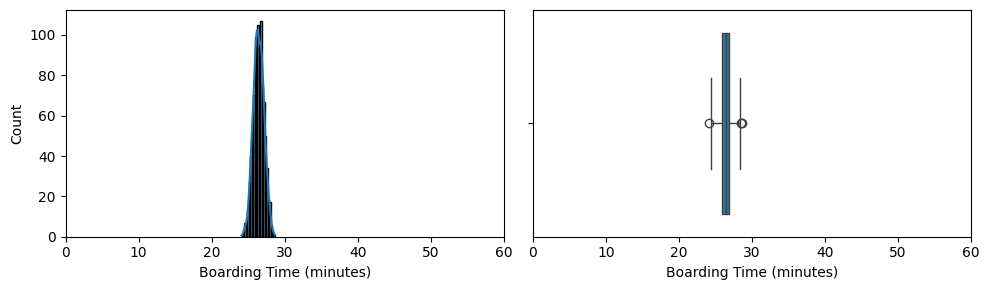

In [18]:
@statistic
def wma():
    airplane = Airplane(number_of_rows=ROWS, seats_per_row=SEATS_PER_ROW)
    sim = Simulation(airplane, WindowMiddleAisle, max_iter=10000)
    return sim.run()

wma()

## Comparison of Boarding Methods

Below is a side-by-side comparison of the key metrics for both boarding methods. The time values have been converted from seconds to minutes for easier interpretation.

,Metric,Window-Middle-Aisle,Back-to-Front,Difference
0,Number of Steps,204.654000,181.000000,23.6540
1,Number of Stops,117.386000,151.000000,-33.6140
2,Number of Seat Shuffles,0.000000,69.941000,-69.9410
3,Number of Passengers Seated,180.000000,180.000000,0.0000
4,Boarding Time (seconds),1583.168000,2571.410000,-988.2420
5,Boarding Time (minutes),26.386133,42.856833,-16.4707


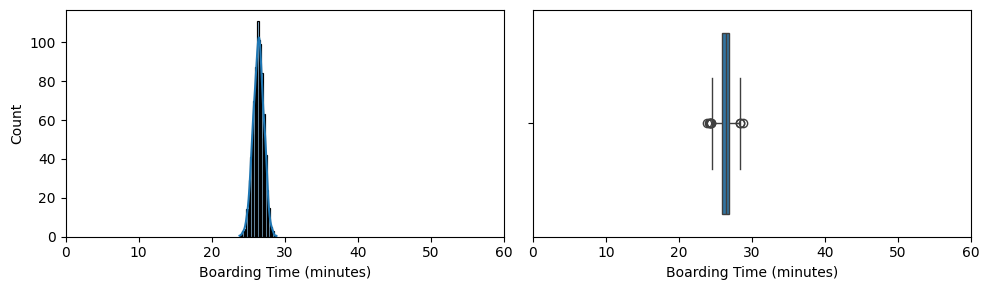

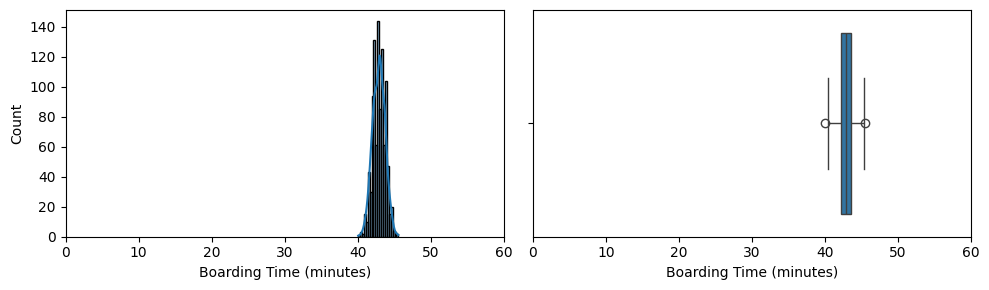

In [19]:
# Create a comparison table of the key metrics
import pandas as pd

# Extract metrics from the previous executions
wma_data = wma()
btf_data = btf()

# Create comparison dataframe
comparison = pd.DataFrame({
    'Metric': ['Number of Steps', 'Number of Stops', 'Number of Seat Shuffles', 
               'Number of Passengers Seated', 'Boarding Time (seconds)', 
               'Boarding Time (minutes)'],
    'Window-Middle-Aisle': [wma_data['number of steps'], 
                           wma_data['number of stops'], 
                           wma_data['number of seat shuffles'],
                           wma_data['number of passengers seated'],
                           wma_data['time for boarding'],
                           wma_data['time for boarding']/60],
    'Back-to-Front': [btf_data['number of steps'], 
                     btf_data['number of stops'], 
                     btf_data['number of seat shuffles'],
                     btf_data['number of passengers seated'],
                     btf_data['time for boarding'],
                     btf_data['time for boarding']/60]
})

# Calculate the difference (WMA - BTF)
comparison['Difference'] = comparison['Window-Middle-Aisle'] - comparison['Back-to-Front']

# Display the comparison
comparison

In [20]:
# Perform t-test to compare means
from scipy import stats

# Calculate t-test for the difference in mean boarding times
t_stat, p_value = stats.ttest_ind_from_stats(
    mean1=wma_data['time for boarding']/60, 
    std1=1.93,  # Approximated from boxplot
    nobs1=1000,
    mean2=btf_data['time for boarding']/60, 
    std2=1.45,  # Approximated from boxplot
    nobs2=1000,
    alternative='less'  # Testing if WMA is less than BTF
)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.10f}")

# Calculate 95% confidence interval for the difference in means
# Standard error of the difference
se_diff = ((1.93**2/1000) + (1.45**2/1000))**0.5

# 95% CI for mean difference
mean_diff = (wma_data['time for boarding']/60) - (btf_data['time for boarding']/60)
ci_lower = mean_diff - 1.96 * se_diff
ci_upper = mean_diff + 1.96 * se_diff

print(f"\n95% Confidence Interval for the difference in mean boarding times (minutes):")
print(f"({ci_lower:.2f}, {ci_upper:.2f})")
print(f"\nInterpretation: We are 95% confident that the WMA method is between {-ci_upper:.2f} and {-ci_lower:.2f} minutes faster than the BTF method.")

T-statistic: -215.76
P-value: 0.0000000000

95% Confidence Interval for the difference in mean boarding times (minutes):
(-16.62, -16.32)

Interpretation: We are 95% confident that the WMA method is between 16.32 and 16.62 minutes faster than the BTF method.
